In [1]:
from data_gen.models import Models
from data_gen.models_dict_v2 import model_dict
from data_gen.generate_synthetic_df import generate_synthetic_df
import numpy as np
import matplotlib.pyplot as plt

SEED = np.random.seed(1)
number_of_samples = 5000
train_ratio, valiation_ratio, test_ratio = 0.6,0.2,0.2 #i.e. 0.6*number_of_samples for training, etc.

# 1. Generate Data

In [2]:
def generate_data(sample_number, seed):
    # Create synthetic dataframe
    df = generate_synthetic_df(sample_number, seed)

    # Instantiate an object from the class "Models"
    models = Models(model_dict)

    # Calculate the cost and price
    cost = models.calculate_cost(df)
    pricing = models.calculate_pricing(df)

    # Calculate the profit on the synthetic dataframe
    df["profit"] = models.calculate_profit(cost, pricing)

    return df

df = generate_data(number_of_samples, SEED)

# 2. Clean Data

In [3]:
def standardize_one_column(column):
    mean = np.mean(column)
    standard_deviation = np.std(column)
    return (column - mean)/standard_deviation

def standardize(dataframe):
    #Given a pandas dataframe, we standardize every column.
    number_of_columns = len(dataframe.columns)
    for j in range(number_of_columns):
        dataframe.iloc[:,j] = standardize_one_column(dataframe.iloc[:,j])
    
    return dataframe

In [4]:
def obtain_X_Y(df):
    X = df.loc[:, df.columns != 'profit']
    Y = df["profit"]

    X.loc[X["MARITAL_STATUS"]=="Single", "MARITAL_STATUS"] = 0
    X.loc[X["MARITAL_STATUS"]=="Not_Single", "MARITAL_STATUS"] = 0

    X = X.astype(int)
    Y = Y.astype(int)

    return X,Y

In [5]:
X,Y = obtain_X_Y(df)

X_TRAIN = X.iloc[:int(train_ratio*number_of_samples),:]
Y_TRAIN = Y.iloc[:int(train_ratio*number_of_samples)]
X_VALIDATION = X.iloc[int(train_ratio*number_of_samples):int((train_ratio+valiation_ratio)*number_of_samples),:]
Y_VALIDATION = Y.iloc[int(train_ratio*number_of_samples):int((train_ratio+valiation_ratio)*number_of_samples)]
X_TEST = X.iloc[int((train_ratio+valiation_ratio)*number_of_samples):,:]
Y_TEST = Y.iloc[int((train_ratio+valiation_ratio)*number_of_samples):]

# 3. Train the Decision Tree.

In [6]:
def MSE(y, y_hat):
    return np.sum( np.square(y-y_hat) )
    

In [7]:
from sklearn.tree import DecisionTreeRegressor

min_error = 999999999999999999999
best_depth = None
best_regressor = None

for k in range(1,15):
    regressor = DecisionTreeRegressor(criterion="squared_error", max_depth=k)
    regressor = regressor.fit(X_TRAIN, Y_TRAIN)
    Y_VALIDATION_HAT = regressor.predict(X_VALIDATION)
    error = MSE(Y_VALIDATION, Y_VALIDATION_HAT)
    if error < min_error:
        min_error = error
        best_depth = k
        best_regressor = regressor

print(k)
print(min_error)

14
652657.5111719511


In [8]:
Y_TEST_HAT = best_regressor.predict(X_TEST)
error = MSE(Y_TEST_HAT, Y_TEST)
print(error)

580348.9376190567


# 4. Get the Transition Matrix

By a **state**, we mean a leaf in the best regressor trained above.
Our first goal is to get a list of all the states and get the decision path (i.e. given X, what leaf does X fall into?).

It turns out that sklearn has one id associated to each tree node. Our `state` will thus be a list of integers corresponding to these leaf nodes.

In [9]:
def get_state(regressor):
    """ Return the indices of the leaf nodes in the decision tree. """
    regressor_tree = regressor.tree_
    return np.where(regressor_tree.children_left == regressor_tree.children_right)[0]

states = get_state(best_regressor)
print(states)

[  9  10  12  13  16  17  19  20  24  25  27  28  31  32  34  35  40  41
  43  44  47  48  50  51  55  56  58  59  62  63  64  70  71  72  74  75
  79  80  81  83  84  88  90  91  94  95  96 100 101 103 104 106 107 114
 115 117 118 121 122 124 125 129 130 131 134 135 137 138 143 144 146 147
 148 152 153 155 156 159 160 161 165 168 169 171 172 175 176 177 182 183
 184 187 188 190 191 192 200 201 203 204 207 208 210 211 215 216 218 219
 222 223 225 226 231 232 234 235 238 239 240 244 245 247 248 251 252 254
 255 261 262 264 265 266 270 271 273 274 277 278 279 284 285 287 288 291
 292 294 295 299 300 302 303 306 307 309 310 317 318 320 321 323 325 326
 330 331 333 334 337 338 340 341 346 347 349 350 353 354 356 357 361 362
 364 365 366 372 373 375 376 379 380 381 384 385 388 389 390 395 396 398
 399 401 403 404 408 409 411 412 415 416 417 426 427 429 430 433 434 436
 437 441 442 444 445 448 449 451 452 456 458 459 462 463 465 466 470 471
 472 474 475 481 482 483 486 487 489 490 494 495 49

In [10]:
def get_profit_list(regressor):
    #this method returns a list such that, the profit of state i is list[i].
    states = get_state(best_regressor)
    value_list = regressor.tree_.value.squeeze()
    return value_list[states]

get_profit_list(best_regressor)

array([ -86.        ,  -73.5       , -137.5       ,  -75.        ,
       -160.41666667, -111.2       , -225.        , -190.875     ,
       -112.19047619,  -76.66666667,  -45.        ,  -81.74074074,
       -121.65625   ,  -83.8       , -139.        , -192.5       ,
        -90.625     , -147.66666667,  -54.44827586,  -73.96491228,
        -53.5       ,  -35.80645161,  -66.33333333, -106.5       ,
        -92.66666667, -141.        ,  -77.125     , -107.2       ,
       -169.8       , -132.        , -225.        , -365.        ,
       -350.        , -332.        , -295.        , -296.        ,
       -132.        , -145.        , -118.        , -252.        ,
       -148.        , -117.        , -139.        , -140.        ,
       -104.        , -112.        ,  -88.        , -146.        ,
       -116.        , -202.66666667, -178.75      ,  -94.        ,
        -97.        ,  -29.8       ,  -12.        ,  -68.05882353,
        -30.        ,  -23.93181818,  -75.5       ,  -40.28571

Now let us print, say, the decision path for `X_TEST`.

In [11]:
def get_state_of_one_year(x, regressor, states):
    x_leaf_id = regressor.apply(x)
    x_states = np.empty(len(x), dtype = np.uint16)
    for k in range(len(x)):
        x_states[k] = np.where(states == x_leaf_id[k])[0][0]
    return x_states

get_state_of_one_year(X_TEST, best_regressor, states)

array([349, 223, 388, 279, 121,   7, 160, 304, 121,  57, 213, 196, 265,
       372, 172, 299, 294, 294, 104,  50, 196, 153,  20, 258, 331, 238,
       268, 133, 238,  13, 312, 362, 357, 405, 211, 357, 383, 382, 121,
       180,   5, 219,  76, 128, 356, 320, 266,  57, 237, 114, 196, 223,
       266, 192, 405, 102, 233, 298,  64, 107,  97, 221, 266, 119, 166,
       336, 217, 100, 249,  68, 218, 107,   1, 151, 266, 235, 172,  97,
       388, 248,   0, 358,  75, 289, 119, 109,  55, 274, 321, 209, 112,
        20,  76, 322, 119,  97,  39, 377, 175, 233, 375, 384, 306,  68,
       217, 119, 259, 174, 336, 104, 223, 261, 240, 195, 292,  76, 207,
       277,  19, 125, 173,  22, 294, 220, 323, 177, 221, 106,  41, 172,
       174, 174, 362,  55, 197, 332, 184, 338,  20, 114, 120, 107, 306,
       172, 186,  55, 119,   4, 367, 221, 270,  19,  20,   2, 174, 258,
       388, 362, 213, 102, 252, 269, 211, 119, 112, 238, 294, 180, 413,
       413, 358, 114, 389, 274, 336, 161, 122, 211,  13,  12, 11

Since the data is random, we will use different seeds to generate $k$ pieces of data of same amound of clients. We assume that such is how one client changes over $k$ years. We shall focus on the mechanism of getting the transition probabilities and will ignore the fact that the client does not age by exactly one year old in the next year.

We remark that, in order for the calculation to work, we must have at least one client for every state. This might not hold. Therefore, we use a large group of clients.

In [12]:
k = 50 #number of years
seeds = np.random.choice(1000, k)
#yearly_X = []
yearly_state = []
sample_number = 5000

for i in range(k):
    new_dataframe = generate_data(sample_number, seeds[i])
    x,_ = obtain_X_Y(new_dataframe)
    #yearly_X.append(x)
    yearly_state.append(get_state_of_one_year(x,best_regressor, states))

print(yearly_state[0])

[121   5 285 ... 291 336 119]


In [13]:
def compute_transition_matrix(yearly_state, number_of_states):
    number_of_years = len(yearly_state)
    number_of_clients = len(yearly_state[0])
    transition_matrix = np.zeros((number_of_states,number_of_states), dtype = np.uint16)

    #For each time t, we count the number of clients starting at state l and end at every state.
    #Once this is done, we make each row a probability vector.

    for t in range(number_of_years-1):
        for n in range(number_of_clients):
            state_this_year = int(yearly_state[t][n])
            state_next_year = int(yearly_state[t+1][n])
            transition_matrix[state_this_year,state_next_year] += 1
    
    transition_matrix = transition_matrix.astype(np.float64)
    for l in range(number_of_states):
        row_sum = np.sum(transition_matrix[l])
        if row_sum == 0:
            transition_matrix[l] = (1/number_of_states)*np.ones(len(transition_matrix[l]))
        else:
            transition_matrix[l] = transition_matrix[l]/row_sum
    
    return transition_matrix

transition_matrix = compute_transition_matrix(yearly_state, len(states))
print(transition_matrix)

[[0.         0.         0.00487805 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.005      0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.00877193 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


# 5. Computation of Customer Lifetime Value(CLV)

Fix a client of Intact.
We are now in a position of defining the concept of customer lifetime value and introduce our algorithm to compute it.

Let $A$ with some $\sigma$-algebra be a measurable space, called the **state space**. For each $t \in \{0,1,2,\cdots\}$, the **client state** is an $A$-valued random variable $S_t$, all defined on one common probability space $(\Omega, F, P)$. For fixed bounded measurable **profit function** $f: A \to \mathbb{R}$ and a **discounting factor** $\gamma = \frac{1}{1.15}$, we define, for every non-negative integer $t_0$ and every $a \in A$:

\begin{equation*}
CLV_{t_0}(a) = \mathbb{E}[\sum_{t=t_0 + 1}^{\tau} \gamma^t f(S_t) \mid S_{t_0} = a]
\end{equation*}

Here $\tau$ is a positive finite stopping time indicating the time which client first quits using Intact. Our goal is to compute $CLV_0(a)$ for every $a \in A$. 

[//]: <1. Enlarge the transition matrix with one row at bottom and one column at right. The bottom right corner of the matrix is $1$. Fill the last row with $0$ and the last column with $0.15$. Normalize the matrix so that it remains a transition matrix. The new state we have added represents the probability of client quiting Intact.>


Let $a \in A$ be given. For every $a' \in A$, we have:

\begin{equation*}
P\{S_1=a' \mid S_0=a\} = P\{S_1=a' \mid S_0=a, \text{client remains}\} P\{ \text{client remains} \mid S_0=a\} 
\end{equation*}

The term $P\{S_1=a' \mid S_0=a, \text{client remains}\}$ on the right hand side is taken care of by the transition matrix computed above. We take $P\{ \text{client remains} \mid S_0=a\} = 0.15$. Generate standard uniform $V$. If $V < P\{ \text{client remains} \mid S_0=a\}$, then the client quits. Otherwise, generate independent standard uniform $U$, which looks at the transition matrix and decide the value of $S_1$. Had simulated the state of $S_t$, repeat in this manner to generate the state of $S_{t+1}$. In doing so, we have generating a sample for the integrand. We then compute the expectation using Kolmogorov's strong law of large numbers.

In [14]:
def generate_sample_paths(number_of_paths, transition_matrix, initial_state, years_limit = 100, client_quit_rate = 0.15):
    sample_paths = []
    for _ in range(number_of_paths):
        sample_paths.append(generate_one_sample_path(transition_matrix, initial_state, years_limit, client_quit_rate))
    return sample_paths

def generate_one_sample_path(transition_matrix, initial_state, years_limit = 100, client_quit_rate = 0.15):
    number_of_states = transition_matrix.shape[0]
    assert initial_state < number_of_states, "State cannot be larger than dimension of matrix."
    sample_path = [initial_state]
    while True:
        v = np.random.uniform(low=0.0, high=1.0, size=1)[0]
        if v < client_quit_rate:
            sample_path.append(-1)
            return sample_path
        last_state = sample_path[-1]
        next_state = np.random.choice([i for i in range(number_of_states)], p=transition_matrix[last_state])
        sample_path.append(next_state)
        if len(sample_path) > years_limit:
            return sample_path

In [15]:
def CLV_one_path(path, profit_list, initial_time = 0, discounting_factor = 1/1.15):
    #Let only one sample path be given. We compute the CLV.
    clv = 0
    for t in range(len(path)):
        if path[t] != -1: #i.e. the client does not quit
            clv += discounting_factor**(initial_time + 1 + t)*profit_list[path[t]]
    return clv

def CLV_estimation(profit_list, initial_state, transition_matrix, initial_time = 0, discounting_factor = 1/1.15, number_of_paths = 10**4):
    sample_paths = generate_sample_paths(number_of_paths, transition_matrix, initial_state, years_limit = 100, client_quit_rate = 0.15)
    clv_samples = np.array([CLV_one_path(path, profit_list, initial_time, discounting_factor) for path in sample_paths])
    return np.mean(clv_samples)


In [16]:
CLV_0 = []
for i in range(len(states)):
    CLV_0.append(CLV_estimation(profit_list = get_profit_list(best_regressor), initial_state= i,
transition_matrix = transition_matrix, initial_time= 0, discounting_factor = 1/1.15, number_of_paths = 10))

print(CLV_0)

[-51.26180852387864, -95.72149137415975, -109.8851714633258, -71.92598024221641, -133.59309852942997, -97.07660464307483, -213.74269254256586, -154.76422496854397, -89.86431701593592, -17.769555910088542, -35.82212432882302, -27.775204590304945, -100.0087049876183, -63.50769471613012, -120.32801815297312, -132.98913215452228, -65.07554069521672, -115.41767593712078, -65.66998481807721, -69.40829229277264, -54.72051017816415, -11.602947128100265, -39.90481635322503, -92.66500975632296, -82.0702811096721, -123.8094054512867, -58.95598339033197, -74.10577408110413, -104.77390263192547, -92.12636054733339, -203.35529987533064, -303.8919142257745, -281.08598735315445, -314.1505561558864, -243.44886034953848, -259.0837066148373, -96.95676599590129, -57.72242437276135, -88.29002079419534, -193.6544115252972, -167.78960987841967, -91.7049896773682, -130.22060512675043, -119.15342536867612, -72.5856065182383, -80.47148003443525, -55.58875253710382, -128.1259452333359, -71.69730092464367, -146.1

C:\Users\Tony\AppData\Local\Temp\ipykernel_7736\895871845.py:30: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Apply a nice style


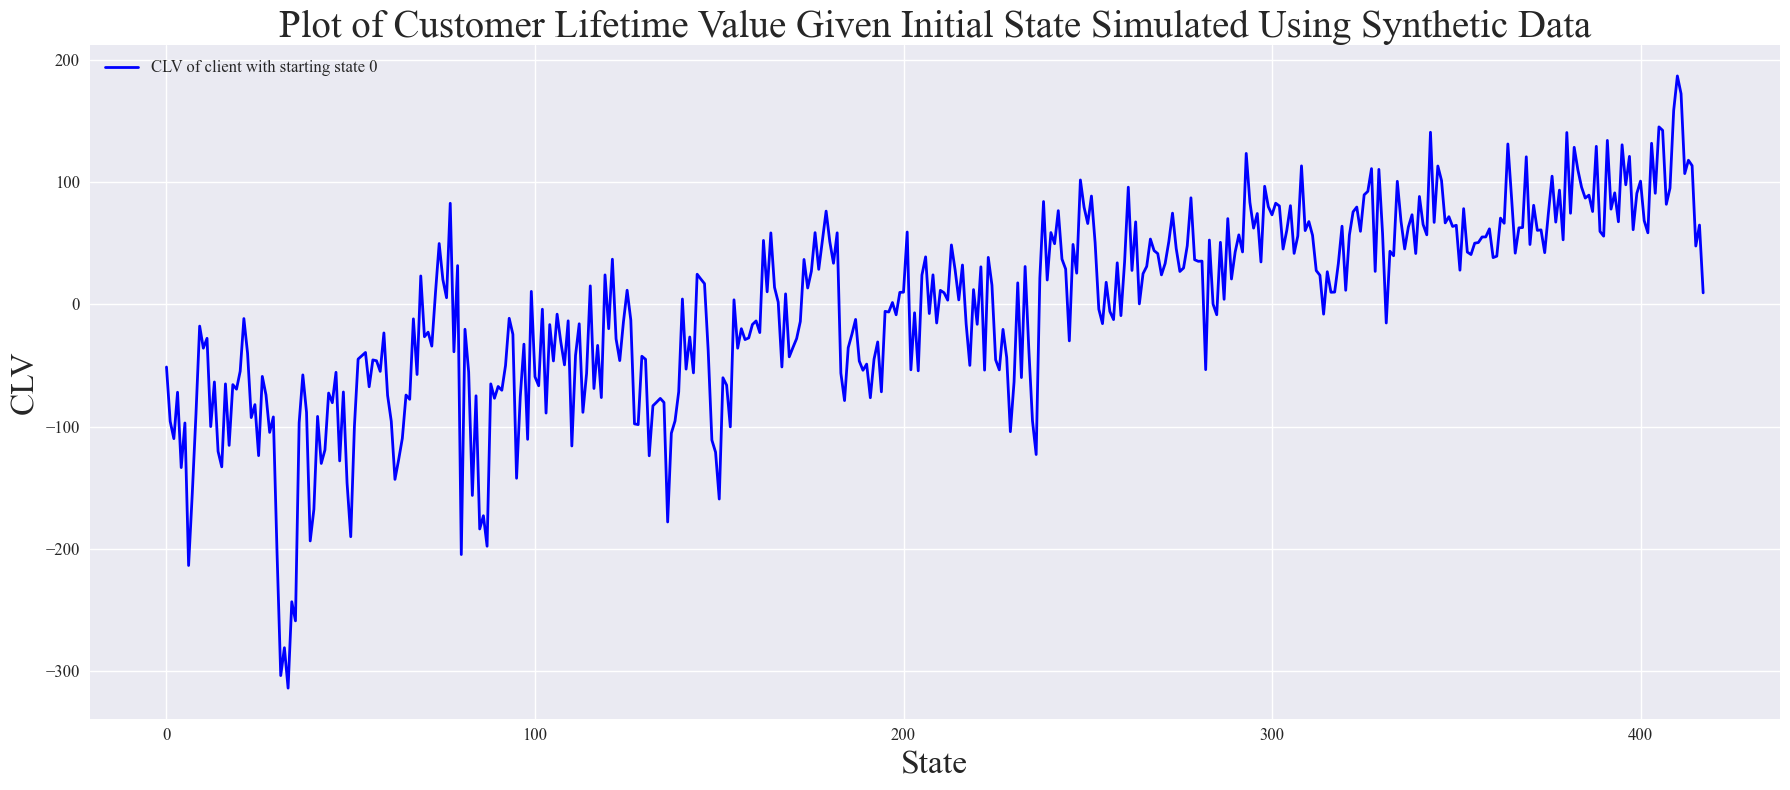

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm

# Set Times New Roman font
font_path = fm.findfont(fm.FontProperties(family='Times New Roman'))
font_prop = fm.FontProperties(fname=font_path, size=12)

# Create some sample data (replace this with your array)
x = np.arange(len(CLV_0))
y = np.array(CLV_0)

# Use Times New Roman font for the whole plot
plt.rcParams['font.family'] = 'Times New Roman'

# Set up the plot
plt.figure(figsize=(18, 8))  # Adjust the figure size as needed
plt.plot(x, y, label='CLV of client with starting state 0', color='blue', linewidth=2)

# Customize plot elements
plt.title('Plot of Customer Lifetime Value Given Initial State Simulated Using Synthetic Data', fontsize=28)
plt.xlabel('State', fontsize=24)
plt.ylabel('CLV', fontsize=24)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)

# Add additional customization for aesthetics
plt.style.use('seaborn')  # Apply a nice style
plt.tight_layout()  # Ensure the plot elements are properly spaced

# Save or display the plot
plt.savefig('result_plot.png')  # Save the plot to a file
plt.show()  # Display the plot on the screen